In [1]:
import argparse
import roypy
import time
import queue
from sample_camera_info import print_camera_info
from roypy_sample_utils import CameraOpener, add_camera_opener_options
#from roypy_platform_utils import PlatformHelper

import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import math
import socket_sender
from matplotlib.path import Path


try:
    import roypycy
except ImportError:
    print("Pico Flexx backend requirements (roypycy) not installed properly")
    raise

# RANSAM

In [2]:
# # RANSAM

def Dis_pt2plane(pts, a, b, c, d):
    """
    Compute the distance from points to the plane
    """
    normal = math.sqrt(a*a+b*b+c*c)
    if normal == 0:
        normal = 1
    
    v = np.array([a,b,c])
    dis = abs(np.dot(pts,v.T)+d)/normal
    return dis

def get_Plane(sampts):
    """
    Compute the equation of the plane
    """
    p1 = sampts[0]
    p2 = sampts[1]
    p3 = sampts[2]
    
    a = ( (p2[1]-p1[1])*(p3[2]-p1[2])-(p2[2]-p1[2])*(p3[1]-p1[1]) )
    b = ( (p2[2]-p1[2])*(p3[0]-p1[0])-(p2[0]-p1[0])*(p3[2]-p1[2]) )
    c = ( (p2[0]-p1[0])*(p3[1]-p1[1])-(p2[1]-p1[1])*(p3[0]-p1[0]) )
    d = ( 0-(a*p1[0]+b*p1[1]+c*p1[2]) )
    
    return a,b,c,d

# def Random3points(points3D, ConfidenceIndex):
#     """
#     Random choose 3 Confidence points
#     """
#     sample_number = 3
#     sample_point_index = random.sample(range(ConfidenceIndex.shape[0]), sample_number)
#     sample_points = np.zeros((sample_number,3))
#     for i in range(sample_number):
#         Confidence_point_index = sample_point_index[i]
#         index = ConfidenceIndex[Confidence_point_index]
#         y = index // points3D.shape[1]
#         x = index % points3D.shape[1]
#         sample_points[i] = points3D[y][x]
#     return sample_points

def Random3points(points3D):
    sample_number = 30
    sample_point_index = random.sample(range(points3D.shape[0]*points3D.shape[1]), sample_number)
    sample_points = np.zeros((3,3))
    num = 0
    for i in range(sample_number):
        index = sample_point_index[i]
        y = index // points3D.shape[1]
        x = index % points3D.shape[1]
        
        point = points3D[y][x]
        if(point[0] != 0 or point[1] != 0 or point[2] != 0):
            sample_points[num] = points3D[y][x]
            num = num + 1
        
        if(num == 3):
            break
    return sample_points

def get_inliner_num(points3D,a,b,c,d,inliner_threshold,Confidence_img):
    """
    Compute the liner points which distance to plane < threshold
    Also get distance from points to the plane (new Depth Image which re-project depth pixels in surface plane)
    """
    inliner_num = 0
    
    dist = Dis_pt2plane(points3D,a,b,c,d)
    inliner_mask = dist < inliner_threshold
    inliner_mask = np.logical_and(inliner_mask, Confidence_img)
    inliner_num = np.sum(inliner_mask)
    return inliner_num, inliner_mask, dist

def RANSAM(points3D, Confidence_img, ransac_iteration = 1000, inliner_threshold = 0.01):
    best_inlinernum = -1
    best_inlinernum = 0
    best_plane = np.zeros((1,4))
    best_depthImage = np.zeros((points3D.shape[0],points3D.shape[1]))
    best_plane_mask = np.zeros((points3D.shape[0],points3D.shape[1]))
    best_sampts = np.zeros((3,3))
    
#     print(points3D.shape,points3D[80:90,110])
    for i in range(ransac_iteration):
        sampts = Random3points(points3D)
        a,b,c,d = get_Plane(sampts)
        
        inliner_num, inliner_mask, depthImage = get_inliner_num(points3D,a,b,c,d,inliner_threshold,Confidence_img)
        if(inliner_num > best_inlinernum):
            best_inlinernum = inliner_num
            best_plane = np.array([a,b,c,d])
            best_plane_mask = inliner_mask
            best_depthImage = depthImage
            best_sampts = sampts
            
    #print("Inliner Number\n", best_inlinernum)
    #print("Inliner plane\n", best_plane)
    return best_plane, best_depthImage, best_plane_mask, best_sampts

In [3]:
def find_target_ellipse(img, quad_mask):
    ret = False
    px = 0
    py = 0
    mask = quad_mask.astype(np.uint8)*255
    circles_image = cv2.add(img, np.zeros(np.shape(img), dtype=np.uint8), mask=mask)
    
    # Set up the detector with default parameters.
    detector = cv2.SimpleBlobDetector_create()

    # Detect blobs.
    keypoints = detector.detect(circles_image)

    if len(keypoints) > 0:
        ret = True
        circles_image = cv2.cvtColor(circles_image, cv2.COLOR_GRAY2BGR)
        circles_image = cv2.drawKeypoints(circles_image, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        px = int(keypoints[-1].pt[0])
        py = int(keypoints[-1].pt[1])
        cv2.circle(circles_image, (px,py), 2, (0,0,225), 2)

    
    return ret, px, py, circles_image

# Draw 3D plane

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_plane(plane_eq):
    a,b,c,d = plane_eq[0], plane_eq[1], plane_eq[2], plane_eq[3]
    x = np.linspace(-1,1,10)
    y = np.linspace(-1,1,10)

    X,Y = np.meshgrid(x,y)
    Z = (d - a*X - b*Y) / c

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    surf = ax.plot_surface(X, Y, Z)

# Tranform Data

In [5]:
def send_plane_eq(plane_eq):
    data = ""
    temp1 = ['1 ']
    temp1.append("%f %f %f %f"%(plane_eq[0], plane_eq[1], plane_eq[2], plane_eq[3]))
    data = data.join(temp1)
#     print('send plane_eq:', data)
    socket_sender.send(data)
    
def send_sample_points(sample_points):
    data = ""
    temp2 = ['2 ']
    for i in range(3): 
        temp2.append("%f %f %f "%(sample_points[i][0], sample_points[i][1], sample_points[i][2]))
    data = data.join(temp2)
#     print('send sample point:', data)
    socket_sender.send(data)
    

# def send_plane_points(points, points_3d, plane_mask, cx, cy):
#     data = ""
#     temp3 = ['3 ']
#     point_num = len(points)
#     temp3.append("%d "%(point_num))
#     for i in range(point_num): 
#         x = points[i,0,0]
#         y = points[i,0,1]
#         if(plane_mask[y,x] == False):
#             x, y = find_points_on_plane(y, x, plane_mask, kernel_size = 15)
#         #if there is still not on the plane than find the point at the center of cx and x
#         if(plane_mask[y,x] == False):
#             i = 40
#             while i>0:
#                 if(plane_mask[y,x] == False):
#                     y1 = y + (cy - y)//i
#                     x1 = x + (cx - x)//i
#                     x, y = find_points_on_plane(y1, x1, plane_mask, kernel_size = 15)
#                     i = i-1
#                 else:
#                     print(i+1)
#                     break
#         temp3.append("%f %f %f "%(points_3d[y,x,0], points_3d[y,x,1], points_3d[y,x,2]))
#     data = data.join(temp3)
# #     print('send plane point:', data)
#     socket_sender.send(data)
    
def send_plane_points(points):
    data = ""
    temp3 = ['3 ']
    point_num = len(points)
    temp3.append("%d "%(point_num))
    for i in range(point_num): 
        x = points[i,0]
        y = points[i,1]
        z = points[i,2]
        temp3.append("%f %f %f "%(x, y, z))
        if i == 3:
            break
    data = data.join(temp3)
#     print('send plane point:', data)
    if point_num > 4:
        print("more than 4 points")
    socket_sender.send(data)
    
def send_plane_center(x, y, points_3d):
    data = ""
    temp4 = ['4 ']
    temp4.append("%f %f %f"%(points_3d[y,x,0], points_3d[y,x,1], points_3d[y,x,2]))
    data = data.join(temp4)
#     print('send plane point:', data)
    socket_sender.send(data)

def send_targetpos(x, y, points_3d):
    data = ""
    temp4 = ['5 ']
    temp4.append("%f %f %f"%(points_3d[y,x,0], points_3d[y,x,1], points_3d[y,x,2]))
    data = data.join(temp4)
#     print('send plane point:', data)
    socket_sender.send(data)
    
def receive_data(cam):
    data = socket_sender.receive()
    if(data != None):
        print("receive " + data)
        ParseData(data, cam)
        
def ParseData(data, cam):
    # split the string at ' '
    msg = data.split(' ')
    # get the first slice of the list
    data_type = int(msg[0])
    
    if(data_type == 1):# change user case
        fps = int(msg[1])
        change_user_case(fps,cam)

# 

In [6]:
def change_user_case(fps,cam):
    if(fps == 5):
        cam.setUseCase('MODE_9_5FPS_2000')
    print("UseCase",cam.getCurrentUseCase())

# find quadrilateral

In [7]:
# def edge(plane_mask):
#     low_threshold = 2
#     high_threshold = 10

#     plane_blur = MorphologyEx(plane_mask)
#     Cannyedges = cv2.Canny(plane_blur, low_threshold, high_threshold)#blur_gray
#     return Cannyedges



# def HoughLines(img):
#     HoughLines_edge = np.zeros((img.shape[0],img.shape[1]))

#     plane_blur = MorphologyEx(img)
#     edges = cv2.Canny(plane_blur,2,10)

#     P = False
#     if(P):
#         #hough transform
#         lines = cv2.HoughLinesP(edges,1,np.pi/180,30,minLineLength=40,maxLineGap=50)
#         if lines is not None:
#             lines1 = lines[:,0,:]#提取为二维
#             for x1,y1,x2,y2 in lines1[:]: 
#                 cv2.line(HoughLines_edge,(x1,y1),(x2,y2),255,2)
#     else:
# #     hough transform
#         lines = cv2.HoughLines(edges,1,np.pi/180,50)
#         if lines is not None:
#             lines1 = lines[:,0,:]#提取为为二维
#             for rho,theta in lines1[:]: 
#                 a = np.cos(theta)
#                 b = np.sin(theta)
#                 x0 = a*rho
#                 y0 = b*rho
#                 x1 = int(x0 + 1000*(-b))
#                 y1 = int(y0 + 1000*(a))
#                 x2 = int(x0 - 1000*(-b))
#                 y2 = int(y0 - 1000*(a)) 
#                 cv2.line(HoughLines_edge,(x1,y1),(x2,y2),255,2)

#     return HoughLines_edge




In [8]:
def MorphologyEx(img):
    kernel_size = 5 #7
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(kernel_size, kernel_size))
    #膨胀之后再腐蚀，在用来关闭前景对象里的小洞或小黑点
    #开运算用于移除由图像噪音形成的斑点
    opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(img,cv2.MORPH_CLOSE,kernel)
    
    kernel_size = 3
    plane_blur = cv2.GaussianBlur(closing,(kernel_size, kernel_size), 0)
    return plane_blur


def find_quadrilateral(img):
    HoughLines_edge = np.zeros((img.shape[0],img.shape[1]))
    cx = 0
    cy = 0
    approx = []
    ret = False
    
    #关闭前景对象里的小洞或小黑点
    blur = MorphologyEx(img)
    image = cv2.cvtColor(blur, cv2.COLOR_GRAY2BGR)
    
    #find Contours with large area
    (_, cnts, _) = cv2.findContours(blur, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    # loop over our contours
    for c in cnts:
        peri = cv2.arcLength(c, True)#輪廓長度
        area = cv2.contourArea(c)
        
        approx = cv2.approxPolyDP(c, 0.08 * peri, True)#把一个连续光滑曲线折线化
        approx = cv2.convexHull(approx)# find凸多邊形框
        if area > 500:
            approx = cv2.approxPolyDP(c, 0.08 * peri, True)#把一个连续光滑曲线折线化
            approx = cv2.convexHull(approx)# find凸多邊形框
            if len(approx) == 4 :
                cv2.drawContours(image, [approx], -1, (255,0,0), 3)
                break
            elif len(approx) > 4:
                k = 0.09
                while k < 0.2 and len(approx) > 4:
                    approx = cv2.approxPolyDP(c, k * peri, True)
                    approx = cv2.convexHull(approx)#find凸多邊形框
                    k = k + 0.03
                    if len(approx) == 4 :
                        cv2.drawContours(image, [approx], -1, (0,0,255), 3)
                        break
            elif len(approx) < 4:
                k = 0.07
                while k > 0.02 and len(approx) < 4:
                    approx = cv2.approxPolyDP(c, k * peri, True)
                    approx = cv2.convexHull(approx)#find凸多邊形框
                    k = k - 0.02
                    if len(approx) == 4 :
                        cv2.drawContours(image, [approx], -1, (0,0,255), 3)
                        break

        if len(approx) == 4 :
            ret = True
            break
    
    if(len(approx)):
        M = cv2.moments(approx)
        if (M['m00'] != 0):
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv2.circle(image, (cx,cy), 3, (0, 255, 255), -1)
        if cy >= img.shape[0] or cx >= img.shape[1] or cx < 0 or cy < 0:
            cx,cy = 0,0
        
    if len(approx) >= 4 :
        ret = True
    
    return ret, image, approx, cx, cy

In [9]:
def find_quad_mask(new_approx, shape):
    height = shape[0]
    width = shape[1]
    mask = np.ones((height,width))
    polygon = []
    
    if (len(new_approx) >= 4):
        polygon=[(new_approx[0,0,1],new_approx[0,0,0]), (new_approx[1,0,1],new_approx[1,0,0]), (new_approx[2,0,1],new_approx[2,0,0]), (new_approx[3,0,1],new_approx[3,0,0])]
    elif (len(new_approx) == 3):
        polygon=[(new_approx[0,0,1],new_approx[0,0,0]), (new_approx[1,0,1],new_approx[1,0,0]), (new_approx[2,0,1],new_approx[2,0,0])]

    if (len(new_approx) >= 3 ):
        successful = True
        poly_path=Path(polygon)

        x, y = np.mgrid[:height, :width]
        coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

        mask = poly_path.contains_points(coors)
        mask = mask.reshape(height, width)
    else:
        successful = False
    return successful, mask

# Find point with depth value

In [10]:
def find_points_on_plane(y, x, mask, kernel_size):
    k = kernel_size//2
    for cy in range(y-k,y+k+1):
        for cx in range(x-k,x+k+1):
            if cx >= 0 and cy >=0 and cx < mask.shape[1] and cy < mask.shape[0] and mask[cy,cx] == True:
                break
                return cx, cy
    
    #if no on the plane ==> 放大kernel size
    kernel_size = kernel_size*2 -1
    k = kernel_size//2
    for cy in range(y-k,y+k+1):
        for cx in range(x-k,x+k+1):
            if cx >= 0 and cy >=0 and cx < mask.shape[1] and cy < mask.shape[0] and mask[cy,cx] == True:
                break
                return cx, cy
    return x, y


def find_plane_points_with_depth_value(points, plane_mask, points_3d, cx, cy):
    point_num = len(points)
    z_points = np.zeros((point_num,3))
    for i in range(point_num): 
        x = points[i,0,0]
        y = points[i,0,1]
        if(plane_mask[y,x] == False):
            x, y = find_points_on_plane(y, x, plane_mask, kernel_size = 15)
        #if there is still not on the plane than find the point at the center of cx and x
        if(plane_mask[y,x] == False):
            k = 40
            while k>0:
                if(plane_mask[y,x] == False):
                    y1 = y + (cy - y)//k
                    x1 = x + (cx - x)//k
                    x, y = find_points_on_plane(y1, x1, plane_mask, kernel_size = 15)
                    k = k-1
                else:
#                     print(k+1)
                    break
        z_points[i,0] = points_3d[y,x,0]
        z_points[i,1] = points_3d[y,x,1]
        z_points[i,2] = points_3d[y,x,2]
        
        points[i,0,0] = x
        points[i,0,1] = y
        
    return z_points, points

In [11]:
def find_reasonable_value_of_center_vertices(cx, cy, plane_mask, approx, points3D, find_quad_img, kernel_size = 7):
    #check if the center is on the plane(for get the reasonable vale of 3d_point)
    #if not ==> check the point nearby the center
    if(plane_mask[cy,cx] == False):
        cx, cy = find_points_on_plane(cy, cx, plane_mask, kernel_size = 7)

    #check if the plane points is on the plane(for get the reasonable vale of 3d_point)
    #points_z : 3d points , new_approx : 2d points
    points_z, new_approx = find_plane_points_with_depth_value(approx, plane_mask, points3D, cx, cy)
    cv2.drawContours(find_quad_img, [new_approx], -1, (0,255,255), 3)
    
    return cx, cy, points_z, new_approx, find_quad_img 
    

# feet_detection

In [12]:
# def feet_detection(depthImg, quad_mask, height = 0.05, feet_height = 0.1):
#     highter_region = depthImg > height
#     lower_region = depthImg < feet_height
#     feet_region = np.logical_and(highter_region, lower_region)
#     Confidence_feet_region = np.logical_and(feet_region, quad_mask)
    
#     return MorphologyEx(Confidence_feet_region.astype(np.uint8))

In [13]:
def feet_detection2(depthImg, mask_successful, quad_mask, height = 0.05, feet_height = 0.1):
    #find the highter_region mask which distance between resulting plane is > height
    #Then find the highter_region_in_quad : the higher region which is inside the quad mask
    highter_region = depthImg > height
    if (mask_successful):
        highter_region_in_quad = np.logical_and(highter_region, quad_mask)
    else:
        highter_region_in_quad = highter_region
        ellipse_list = []
        feet_region_with_Ellipses = np.zeros(depthImg.shape)
        return feet_region_with_Ellipses, ellipse_list
    
    #find the mask of the max contourArea in highter_region_in_quad ==> find the body, leg, and feet
    area = 0
    max_highter_region = np.zeros(depthImg.shape)
    (_, cnts, _) = cv2.findContours(highter_region_in_quad.astype(np.uint8)*255, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
    if len(cnts) >= 1 :
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:2]
        for c in cnts:
            area = cv2.contourArea(c)
            if area > 1000: #the body, leg, and feet area > 1000
                #依Contours圖形建立mask
                cv2.drawContours(max_highter_region, [c], -1, True, -1) #255        →白色, -1→塗滿
        
    
    #find the lower_region mask which distance between resulting plane is < feet_height
    #feet_region : max_highter_region which distance between resulting plane is < feet_height
    lower_region = depthImg < feet_height
    feet_region = np.logical_and(max_highter_region, lower_region)
    
    feet_region_smooth = MorphologyEx(feet_region.astype(np.uint8))
    
    feet_region_with_Ellipses, ellipse_list = fit_Ellipses(feet_region_smooth)
    
    return feet_region_with_Ellipses, ellipse_list

In [14]:
def fit_Ellipses(feet_region):
    image = cv2.cvtColor(feet_region.astype(np.uint8)*255, cv2.COLOR_GRAY2BGR)
    ellipse_List = []
    (_, cnts, _) = cv2.findContours(feet_region, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:2]
    
    # loop over our contours
    for c in cnts:
        area = cv2.contourArea(c)
        if area > 50 and len(c) >= 5:
            ellipse = cv2.fitEllipse(c)
            Area = Ellipse_area(ellipse[1][0], ellipse[1][1])
            if Area > 50 and Area < 1600 and area/Area > 0.7:
                ellipse_List.append(cv2.fitEllipse(c))
                cv2.ellipse(image, ellipse, (0,255,255), 2)

    return image, ellipse_List

In [15]:
def Ellipse_area(a2, b2):
    a = a2 / 2
    b = b2 / 2
    Area = 3.142 * a * b 
    
    #長寬比
    if( a > b*3):
        return 0

    return Area 


def find_foci(image, ellipse_List):
    for ellipse in ellipse_List:
        a = ellipse[1][0] / 2
        b = ellipse[1][1] / 2
        c = np.sqrt(np.power(a,2) - np.power(b,2))
        
        x = ellipse[0][0] + c * np.cos(ellipse[2])
        y = ellipse[0][1] + c * np.sin(ellipse[2])
        cv2.circle(image, (x,y), 5 , (255,255,0) , 3)

In [16]:
def showimg_by_plt(data):
    # create a figure and show the raw data
    plt.figure(1)
    plt.imshow(data)

    plt.show(block = False)
    plt.draw()
    # this pause is needed to ensure the drawing for
    # some backends
    plt.pause(0.001)

# Main

In [29]:


class MyListener(roypy.IDepthDataListener):
    def __init__(self, xqueue, yqueue, zqueue, grayValuequeue):
        super(MyListener, self).__init__()
        self.xqueue = xqueue
        self.yqueue = yqueue
        self.zqueue = zqueue
        self.grayValuequeue = grayValuequeue
        self.Listening = True

    def onNewData(self, data):   
        if(self.Listening):
            t_time = time.time()
            
            xvalues = []
            yvalues = []
            zvalues = []
            grayvalues = []
            
            values = roypycy.get_backend_data(data)

            xvalues = values.x
            yvalues = values.y
            zvalues = values.z
            grayvalues = values.grayValue

            xarray = np.asarray(xvalues)
            yarray = np.asarray(yvalues)
            zarray = np.asarray(zvalues)
            
            
            q_x = xarray.reshape (-1, data.width)        
            self.xqueue.put(q_x)
            q_y = yarray.reshape (-1, data.width)        
            self.yqueue.put(q_y)
            q_z = zarray.reshape (-1, data.width)        
            self.zqueue.put(q_z)
            
            q_grayvalues = grayvalues.reshape (-1, data.width)        
            self.grayValuequeue.put(q_grayvalues)
            
            #print('store time:', (time.time()-t_time))

    def paint (self, data, name):
        """Called in the main thread, with data containing one of the items that was added to the
        queue in onNewData.
        """
        cv2.namedWindow(name, cv2.WINDOW_NORMAL)
        cv2.imshow(name, data)
        cv2.waitKey(1)


def main ():
    parser = argparse.ArgumentParser (usage = __doc__)
    add_camera_opener_options (parser)
    parser.add_argument ("--seconds", type=int, default=15, help="duration to capture data")
    timer_show = False
    
    Replay = False
    if(Replay == True):
        options = parser.parse_args(args=['--rrf', 'feet02.rrf','--seconds', '25'])
    else:
        options = parser.parse_args(args=['--seconds', '30'])

    opener = CameraOpener (options)
    cam = opener.open_camera ()
    
    if(Replay == False):
        cam.setUseCase('MODE_5_35FPS_600')#MODE_9_5FPS_2000 MODE_5_45FPS_500

    #Print camera information
    print_camera_info (cam)
    print("isConnected", cam.isConnected())
    print("getFrameRate", cam.getFrameRate())
    print("UseCase",cam.getCurrentUseCase())

    # we will use this queue to synchronize the callback with the main
    # thread, as drawing should happen in the main thread 
    x = queue.LifoQueue()
    y = queue.LifoQueue()
    z = queue.LifoQueue()
    grayvalue = queue.LifoQueue()
    l = MyListener(x,y,z,grayvalue)
    cam.registerDataListener(l)
    cam.startCapture()
    
    # create a loop that will run for a time (default 15 seconds)
    process_event_queue (x, y, z, grayvalue, l, options.seconds, cam)
    cam.stopCapture()
    socket_sender.close_socket()
    
    cv2.destroyAllWindows()
    

def process_event_queue (x,y,z,grayvalue, painter, seconds, cam):
    show_3d_plane_img = False 
    SendData = True
    
    
    # create a loop that will run for the given amount of time
#     t_end = time.time() + seconds
#     while time.time() < t_end:
        
#     key = ''
    print("  Quit : Q\n")
    while 1 :
        try:
            # try to retrieve an item from the queue.
            # this will block until an item can be retrieved
            # or the timeout of 1 second is hit
            t_time = time.time()
            
            item_x = x.get(True, 0.5)
            item_y = y.get(True, 0.5)
            item_z = z.get(True, 0.5)
            points3D = np.dstack((item_x,item_y,item_z))
            item_grayvalue = grayvalue.get(True, 0.5)
            #print('queue time:', (time.time()-t_time))
        except queue.Empty:
            # this will be thrown when the timeout is hit
            break
        else:
            
            t_time = time.time()
            #if there have z value(z != 0) ==> True
            Confidence_img = points3D[:,:,2] != 0 
#             surface_plane, depthImg, plane_mask, best_sampts = RANSAM(points3D, ConfidenceIndex, ransac_iteration = 500, inliner_threshold = 0.003)
            surface_plane, depthImg, plane_mask, best_sampts = RANSAM(points3D, Confidence_img, ransac_iteration = 50, inliner_threshold = 0.01)#1cm  0.003
#             print('Ransam time:', (time.time()-t_time))
            
            #turn bool img to uint8
            plane_img = plane_mask.astype(np.uint8)*255  
            #turn item_grayvalue to uint8
            grayvalue_img = cv2.convertScaleAbs(item_grayvalue)
            
            # y * -1 then compute the plane again ==> result : normal x * -1, z * -1            
#             sampts = best_sampts.copy()
#             sampts[:,1] = sampts[:,1] * -1
#             print(best_sampts,sampts)
#             print(surface_plane)
#             print(get_Plane(sampts))
            

            #暫時不用，未來可能需要
            #find large 四邊形 on the mask of plane, and find the center of it
            quad_success, find_quad_img, approx, cx, cy = find_quadrilateral(plane_img)
            
#             find large 四邊形 successful ==> update cx, cy 
            if quad_success:
                #check if the center and plane points are on the plane(for get the reasonable vale of 3d_point)
                cx, cy, points_z, new_approx, find_quad_img = find_reasonable_value_of_center_vertices(cx, cy, plane_mask, approx, points3D, find_quad_img, kernel_size = 7)

                #get mask of quadrilateral ==> no need to find new_approx (reasonable_value of edge points)??
#                 mask_successful, quad_mask = find_quad_mask(new_approx, plane_img.shape)
                mask_successful, quad_mask = find_quad_mask(approx, plane_img.shape)

                #find circle
                ret, px, py, circles_image = find_target_ellipse(grayvalue_img, quad_mask)
                if ret:
                    targetpos = (px, py)
                    if(plane_mask[py,px] == False):
                        px, py = find_points_on_plane(py, px, plane_mask, kernel_size = 7)
#                     print(points3D[py, px])
                    if(SendData):
                        send_targetpos(px, py, points3D)
            
            
#             #feet_detection
#             feet_img, ellipse_list = feet_detection2(depthImg, mask_successful, quad_mask, height = 0.02, feet_height = 0.1)
                
            #show image
            painter.paint (item_z, 'Depth')
            painter.paint (circles_image, 'circles_image')
#             painter.paint (plane_img, 'plane')
#             painter.paint (find_quad_img, 'find_quad_img')
#             painter.paint (quad_mask.astype(np.uint8)*255, 'quad_mask_img')
#             painter.paint (feet_img, 'feet_img')
#             painter.paint (Confidence_img.astype(np.uint8)*255, 'Confidence_img')
            if(show_3d_plane_img):
                show_plane(surface_plane)
#             if len(new_approx) > 4:
#                 plt.imshow(find_quad_img),plt.axis('off')
#                 plt.show()
            
            #Send surface_plane and best_sampts
            #receive data from unity
            if(SendData):
#                 socket_sender.create_socket()
                send_plane_eq(surface_plane)
#                 send_sample_points(best_sampts)
                send_plane_points(points_z)
#                 send_plane_center(cx, cy, points3D)
                receive_data(cam)
            
#             print('time:', (time.time()-t_time))
        
        
                
        if(cv2.waitKey(10) & 0xFF == 113):
            break


In [39]:
main()

Number of cameras connected:  1
        Camera information
Type:            PICOFLEXX
Width:           224
Height:          171
Operation modes: 10
    MODE_9_5FPS_2000
    MODE_9_10FPS_1000
    MODE_9_15FPS_700
    MODE_9_25FPS_450
    MODE_5_35FPS_600
    MODE_5_45FPS_500
    MODE_MIXED_30_5
        this operation mode has 2 streams
    MODE_MIXED_50_5
        this operation mode has 2 streams
    Low_Noise_Extended
    Fast_Acquisition
Lens parameters: 9
    ('cx', 118.28559112548828)
    ('cy', 87.74105072021484)
    ('fx', 213.8031768798828)
    ('fy', 213.8031768798828)
    ('k1', 0.4155448377132416)
    ('k2', -4.7316107749938965)
    ('k3', 8.45906925201416)
    ('p1', 7.605663946304829e-16)
    ('p2', 4.939198934392371e-16)
CameraInfo items: 8
    ('BRIDGE_TYPE', 'Enclustra')
    ('MODULE_IDENTIFIER', '00000000')
    ('MODULE_IDENTIFIER_HASH', '558161692')
    ('MODULE_SERIAL', '0')
    ('MODULE_SUFFIX', '')
    ('IMAGER', 'M2450_A12_AIO')
    ('PROCESSING_NAME', 'Spectre')
  

In [19]:
socket_sender.close_socket()

close the socket successful


In [20]:
#  !jupyter nbconvert --to script HMD_Light_main.ipynb

In [21]:
# import socket_sender
# socket_sender.send('0 hello world')
# data = socket_sender.receive()
# print(data)
# socket_sender.close_socket()

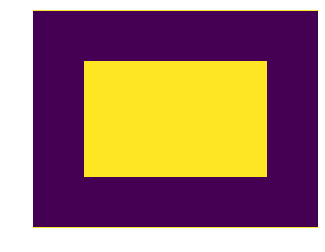

In [22]:
#show plane edge
test = np.zeros((171,224), np.uint8)
l = 40
test[l:171-l,l:224-l] = 255
test[test.shape[0]-1,:] = 255
test[0,:] = 255
plt.imshow(test),plt.axis('off')
plt.show()

In [23]:
(_, cnts, _) = cv2.findContours(test, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.08 * peri, True)
    print(c)
    print("//")
    print(approx)
    print("________")

[[[ 40  40]]

 [[ 40 130]]

 [[183 130]]

 [[183  40]]]
//
[[[ 40  40]]

 [[ 40 130]]

 [[183 130]]

 [[183  40]]]
________
[[[  0 170]]

 [[223 170]]]
//
[[[  0 170]]

 [[223 170]]]
________
[[[  0   0]]

 [[223   0]]]
//
[[[  0   0]]

 [[223   0]]]
________


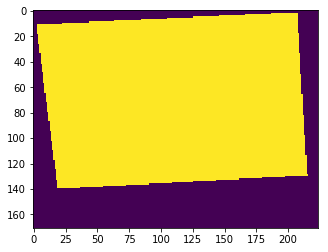

In [24]:
import pylab as plt
import numpy as np
from matplotlib.path import Path

width, height=224, 171

polygon=[(129, 215), (140, 19), (11, 2), (1, 207)]
poly_path=Path(polygon)

x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask = poly_path.contains_points(coors)
mask= mask.reshape(height, width)
plt.imshow(mask.astype(np.uint8)*255)
plt.show()